# 🔍 Exploration et Visualisation de l'Espace de Conception
 
 Ce notebook explore l'impact des paramètres sur les performances de la chaîne d'approvisionnement.


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.express as px
from ipywidgets import interact, widgets
import pickle
import sys
import os
import importlib

# Ajouter le répertoire courant au path
current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.insert(0, current_dir)

# Vérifier si le fichier existe
supply_chain_file = os.path.join(current_dir, 'supply_chain_simple.py')
print(f"Fichier existe: {os.path.exists(supply_chain_file)}")

# Déboguer le contenu du module
try:
    import supply_chain_simple
    # Forcer le rechargement
    importlib.reload(supply_chain_simple)
    
    # Vérifier quelles fonctions sont disponibles
    available_functions = [name for name in dir(supply_chain_simple) if not name.startswith('_')]
    print(f"Fonctions disponibles: {available_functions}")
    
    # Import des fonctions
    run_multiple_simulations = supply_chain_simple.run_multiple_simulations
    run_simulation = supply_chain_simple.run_simulation
    
    print("✅ Import réussi!")
    
except Exception as e:
    print(f"❌ Erreur: {e}")
    print("Chargement direct du fichier...")
    exec(open('supply_chain_simple.py', encoding='utf-8').read())

Fichier existe: True
Fonctions disponibles: ['Dict', 'List', 'Optional', 'Retailer', 'SimulationResults', 'SupplyChainNode', 'Tuple', 'Wholesaler', 'customer_generator', 'customer_purchase', 'dataclass', 'evaluate_supply_chain', 'np', 'random', 'run_multiple_simulations', 'run_simulation', 'simpy']
✅ Import réussi!


 # 📊 Analyse de sensibilité univariée
 
 Commençons par analyser l'impact de chaque paramètre individuellement.


In [18]:

def sensitivity_analysis_1d(param_name, param_range, base_params, config, n_reps=10):
    """Analyse de sensibilité pour un paramètre"""
    results = []
    
    for value in param_range:
        # Copier les paramètres de base et modifier celui étudié
        params = base_params.copy()
        params[param_name] = value
        
        # Exécuter les simulations
        stats, _ = run_multiple_simulations(params, config, n_replications=n_reps)
        
        results.append({
            param_name: value,
            'profit_moyen': stats['profit_net_mean'],
            'profit_std': stats['profit_net_std'],
            'taux_service': stats['taux_service_mean'],
            'stock_grossiste': stats['stock_moyen_grossiste_mean'],
            'stock_detaillant': stats['stock_moyen_detaillant_mean']
        })
    
    return pd.DataFrame(results)

# Paramètres de base (centre de l'espace)
base_params = {
    'S_grossiste': 900,
    's_grossiste': 350,
    'S_detaillant': 200,
    's_detaillant': 65
}

# Analyse pour S_detaillant
print("🔍 Analyse de sensibilité pour S_detaillant...")
S_range = np.linspace(BOUNDS['S_detaillant'][0], BOUNDS['S_detaillant'][1], 15)
df_S = sensitivity_analysis_1d('S_detaillant', S_range, base_params, CONFIG, n_reps=10)

🔍 Analyse de sensibilité pour S_detaillant...


## 📈 Visualisation de l'impact de S_détaillant


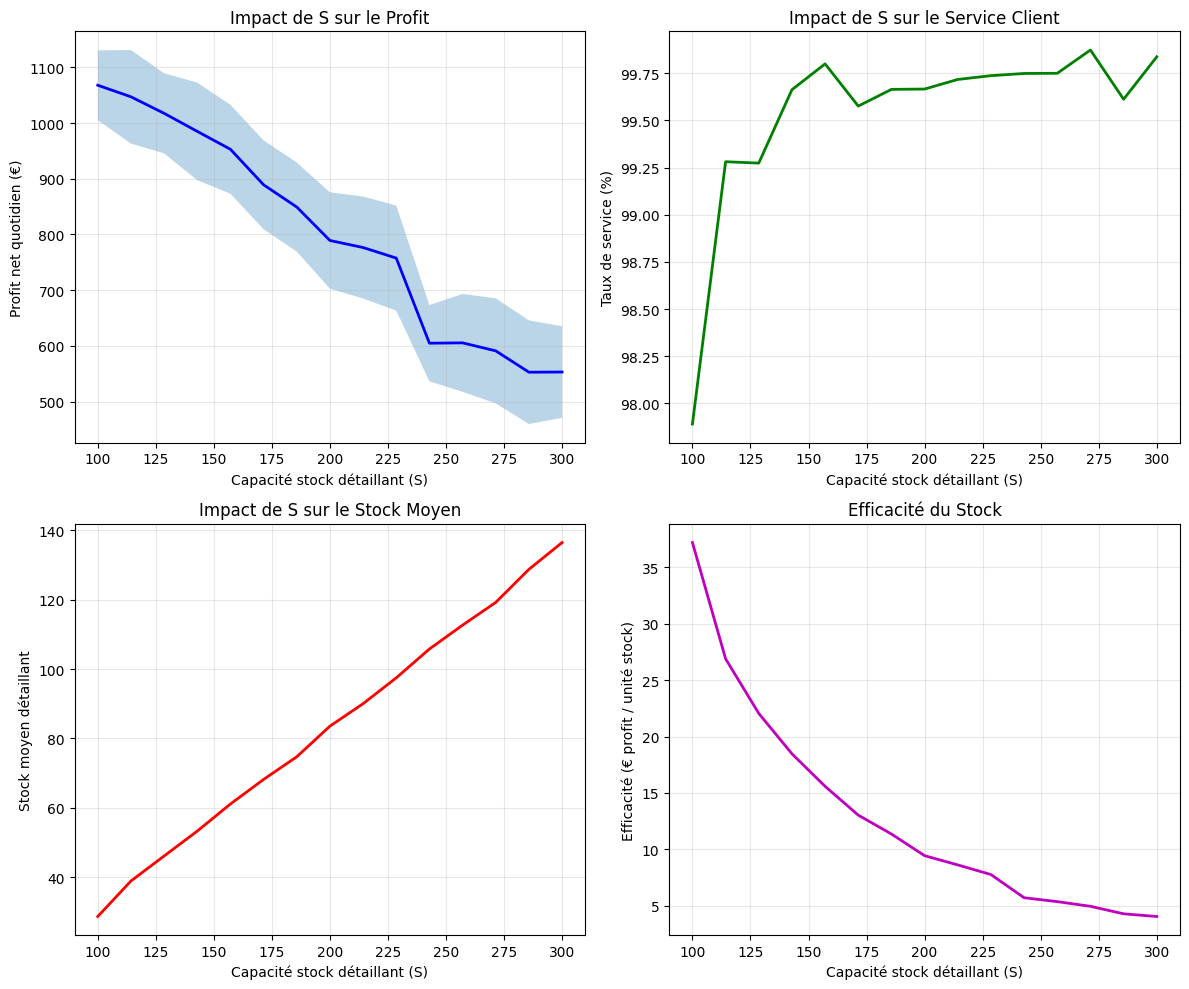


📍 S_détaillant optimal ≈ 100
   Profit associé: 1067.81€/jour


In [19]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Profit vs S_detaillant
ax = axes[0, 0]
ax.plot(df_S['S_detaillant'], df_S['profit_moyen'], 'b-', linewidth=2)
ax.fill_between(df_S['S_detaillant'], 
                df_S['profit_moyen'] - df_S['profit_std'],
                df_S['profit_moyen'] + df_S['profit_std'],
                alpha=0.3)
ax.set_xlabel('Capacité stock détaillant (S)')
ax.set_ylabel('Profit net quotidien (€)')
ax.set_title('Impact de S sur le Profit')
ax.grid(True, alpha=0.3)

# Taux de service vs S_detaillant
ax = axes[0, 1]
ax.plot(df_S['S_detaillant'], df_S['taux_service'] * 100, 'g-', linewidth=2)
ax.set_xlabel('Capacité stock détaillant (S)')
ax.set_ylabel('Taux de service (%)')
ax.set_title('Impact de S sur le Service Client')
ax.grid(True, alpha=0.3)

# Stock moyen vs S_detaillant
ax = axes[1, 0]
ax.plot(df_S['S_detaillant'], df_S['stock_detaillant'], 'r-', linewidth=2)
ax.set_xlabel('Capacité stock détaillant (S)')
ax.set_ylabel('Stock moyen détaillant')
ax.set_title('Impact de S sur le Stock Moyen')
ax.grid(True, alpha=0.3)

# Ratio profit/stock
ax = axes[1, 1]
efficiency = df_S['profit_moyen'] / df_S['stock_detaillant']
ax.plot(df_S['S_detaillant'], efficiency, 'm-', linewidth=2)
ax.set_xlabel('Capacité stock détaillant (S)')
ax.set_ylabel('Efficacité (€ profit / unité stock)')
ax.set_title('Efficacité du Stock')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/figures/sensitivity_S_detaillant.png', dpi=300)
plt.show()

# Point optimal approximatif
optimal_idx = df_S['profit_moyen'].idxmax()
print(f"\n📍 S_détaillant optimal ≈ {df_S.loc[optimal_idx, 'S_detaillant']:.0f}")
print(f"   Profit associé: {df_S.loc[optimal_idx, 'profit_moyen']:.2f}€/jour")


# ## 🔄 Analyse de l'interaction S-s (politique de stock)

In [20]:
# Créer une grille pour explorer l'interaction S-s du détaillant
S_values = np.linspace(BOUNDS['S_detaillant'][0], BOUNDS['S_detaillant'][1], 10)
s_values = np.linspace(BOUNDS['s_detaillant'][0], BOUNDS['s_detaillant'][1], 10)

print("🔄 Exploration de l'interaction S-s (10x10 points)...")
profit_grid = np.zeros((len(s_values), len(S_values)))
service_grid = np.zeros((len(s_values), len(S_values)))

for i, s in enumerate(s_values):
    for j, S in enumerate(S_values):
        if s < S:  # Contrainte: s doit être inférieur à S
            params = base_params.copy()
            params['S_detaillant'] = S
            params['s_detaillant'] = s
            
            # Simulation rapide (moins de réplications)
            stats, _ = run_multiple_simulations(params, CONFIG, n_replications=5)
            profit_grid[i, j] = stats['profit_net_mean']
            service_grid[i, j] = stats['taux_service_mean']
        else:
            profit_grid[i, j] = np.nan
            service_grid[i, j] = np.nan
    
    print(f"  Progression: {(i+1)/len(s_values)*100:.0f}%", end='\r')

print("\n✅ Exploration terminée")

🔄 Exploration de l'interaction S-s (10x10 points)...
  Progression: 100%
✅ Exploration terminée


# 🗺️ Carte de chaleur Profit = f(S, s)

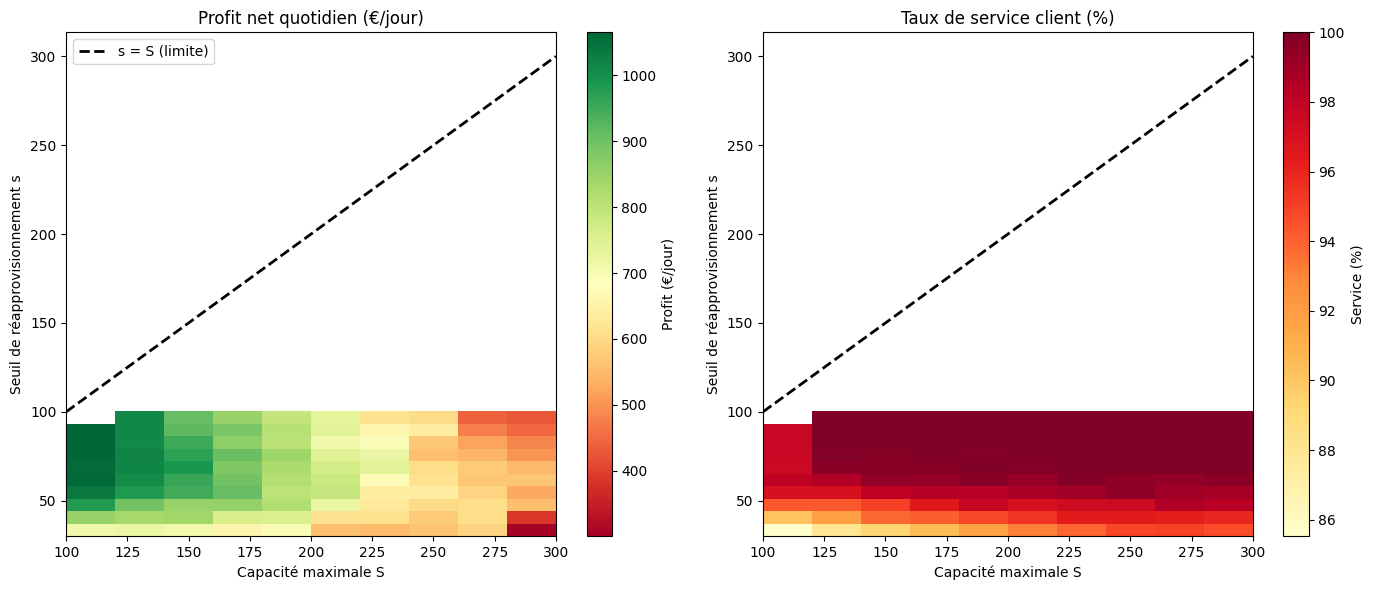


📍 Configuration optimale approximative:
   s = 77, S = 100
   Profit = 1065.36€/jour


In [23]:
# Masquer les valeurs invalides
masked_profit = np.ma.masked_invalid(profit_grid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Carte de profit
im1 = ax1.imshow(masked_profit, extent=[S_values[0], S_values[-1], 
                                        s_values[0], s_values[-1]],
                 origin='lower', aspect='auto', cmap='RdYlGn')
ax1.set_xlabel('Capacité maximale S')
ax1.set_ylabel('Seuil de réapprovisionnement s')
ax1.set_title('Profit net quotidien (€/jour)')

# Ajouter la diagonale s=S
ax1.plot([S_values[0], S_values[-1]], [S_values[0], S_values[-1]], 
         'k--', linewidth=2, label='s = S (limite)')
ax1.legend()

# Colorbar
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('Profit (€/jour)')

# Carte de service
masked_service = np.ma.masked_invalid(service_grid * 100)
im2 = ax2.imshow(masked_service, extent=[S_values[0], S_values[-1], 
                                         s_values[0], s_values[-1]],
                 origin='lower', aspect='auto', cmap='YlOrRd')
ax2.set_xlabel('Capacité maximale S')
ax2.set_ylabel('Seuil de réapprovisionnement s')
ax2.set_title('Taux de service client (%)')
ax2.plot([S_values[0], S_values[-1]], [S_values[0], S_values[-1]], 
         'k--', linewidth=2)

# Colorbar
cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label('Service (%)')

plt.tight_layout()
plt.savefig('results/figures/heatmap_S_s_interaction.png', dpi=300)
plt.show()

# Trouver le maximum
max_idx = np.unravel_index(np.nanargmax(masked_profit), masked_profit.shape)
print(f"\n📍 Configuration optimale approximative:")
print(f"   s = {s_values[max_idx[0]]:.0f}, S = {S_values[max_idx[1]]:.0f}")
print(f"   Profit = {masked_profit[max_idx]:.2f}€/jour")

# 🌐 Visualisation 3D interactive

In [24]:
# Créer une surface 3D avec Plotly
X, Y = np.meshgrid(S_values, s_values)

fig = go.Figure()

# Surface du profit
fig.add_trace(go.Surface(
    x=X, y=Y, z=masked_profit,
    name='Profit',
    colorscale='RdYlGn',
    showscale=True,
    colorbar=dict(title="Profit (€/jour)", x=1.0)
))

# Ajouter des contours
fig.add_trace(go.Contour(
    x=S_values, y=s_values, z=masked_profit,
    showscale=False,
    contours=dict(
        coloring='lines',
        showlabels=True,
    ),
    line=dict(width=3)
))

fig.update_layout(
    title='Surface de Profit: Interaction S-s du Détaillant',
    scene=dict(
        xaxis_title='Capacité S',
        yaxis_title='Seuil s',
        zaxis_title='Profit (€/jour)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
    ),
    width=900,
    height=700
)

fig.show()

# ## 🎯 Analyse multi-objectifs: Profit vs Service


In [25]:
# Échantillonner différentes configurations
n_samples = 100
sample_configs = []
sample_results = []

print(f"🎯 Échantillonnage de {n_samples} configurations...")

for i in range(n_samples):
    # Échantillonnage aléatoire uniforme
    params = {
        'S_grossiste': np.random.uniform(*BOUNDS['S_grossiste']),
        's_grossiste': np.random.uniform(*BOUNDS['s_grossiste']),
        'S_detaillant': np.random.uniform(*BOUNDS['S_detaillant']),
        's_detaillant': np.random.uniform(*BOUNDS['s_detaillant'])
    }
    
    # Vérifier les contraintes
    if params['s_grossiste'] < params['S_grossiste'] and \
       params['s_detaillant'] < params['S_detaillant']:
        
        # Simulation
        results, _, _ = run_simulation(params, CONFIG, verbose=False)
        
        sample_configs.append(params)
        sample_results.append({
            'profit': results.profit_net,
            'service': results.taux_service * 100,
            'stock_total': results.stock_moyen_grossiste + results.stock_moyen_detaillant
        })
    
    if (i+1) % 10 == 0:
        print(f"  Progression: {(i+1)/n_samples*100:.0f}%", end='\r')

print("\n✅ Échantillonnage terminé")

# Convertir en DataFrame
df_samples = pd.DataFrame(sample_results)
df_configs = pd.DataFrame(sample_configs)

🎯 Échantillonnage de 100 configurations...
  Progression: 100%
✅ Échantillonnage terminé


# ## 📊 Front de Pareto: Profit vs Service


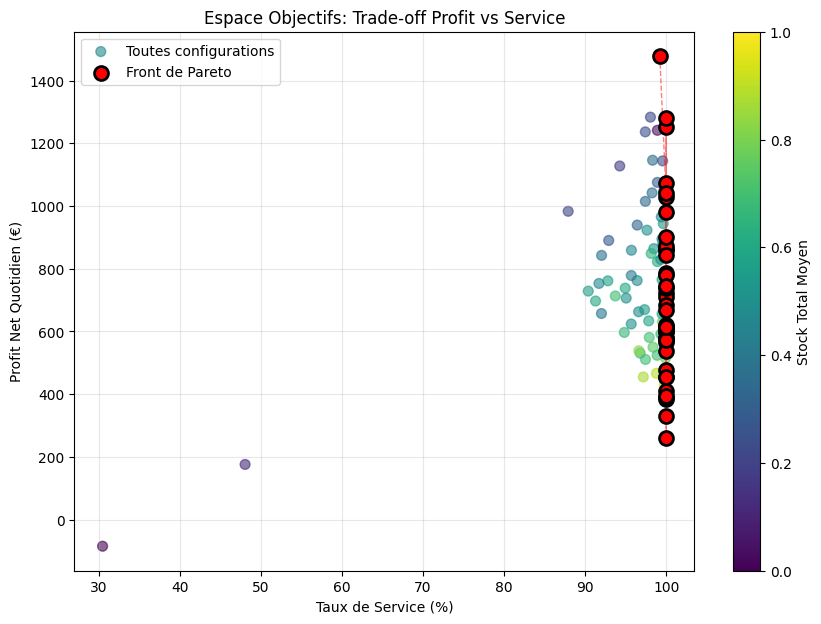


🏆 Exemples de configurations Pareto-optimales:

Configuration 74:
  Profit: 1477.90€/jour
  Service: 99.2%
  Paramètres: S_g=632, s_g=295, S_d=147, s_d=62

Configuration 61:
  Profit: 1281.31€/jour
  Service: 100.0%
  Paramètres: S_g=660, s_g=272, S_d=180, s_d=95

Configuration 4:
  Profit: 1252.03€/jour
  Service: 100.0%
  Paramètres: S_g=602, s_g=332, S_d=146, s_d=82


In [26]:
# Identifier le front de Pareto
def is_pareto_efficient(costs):
    """
    Trouve les points Pareto-efficaces
    costs: array où on veut minimiser toutes les colonnes
    """
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            # Garder les points qui ne sont pas dominés
            is_efficient[is_efficient] = np.any(costs[is_efficient] <= c, axis=1)
            is_efficient[i] = True
    return is_efficient

# Transformer en problème de minimisation (négation du profit et service)
costs = np.column_stack((-df_samples['profit'], -df_samples['service']))
pareto_mask = is_pareto_efficient(costs)

# Visualisation
plt.figure(figsize=(10, 7))

# Tous les points
plt.scatter(df_samples['service'], df_samples['profit'], 
           c=df_samples['stock_total'], cmap='viridis', 
           alpha=0.6, s=50, label='Toutes configurations')

# Front de Pareto
plt.scatter(df_samples.loc[pareto_mask, 'service'], 
           df_samples.loc[pareto_mask, 'profit'],
           color='red', s=100, edgecolors='black', 
           linewidth=2, label='Front de Pareto', zorder=5)

# Relier les points Pareto
pareto_points = df_samples.loc[pareto_mask].sort_values('service')
plt.plot(pareto_points['service'], pareto_points['profit'], 
        'r--', linewidth=1, alpha=0.5)

plt.xlabel('Taux de Service (%)')
plt.ylabel('Profit Net Quotidien (€)')
plt.title('Espace Objectifs: Trade-off Profit vs Service')
plt.colorbar(label='Stock Total Moyen')
plt.legend()
plt.grid(True, alpha=0.3)

plt.savefig('results/figures/pareto_front.png', dpi=300)
plt.show()

# Quelques configurations Pareto-optimales
print("\n🏆 Exemples de configurations Pareto-optimales:")
pareto_configs = df_configs.loc[pareto_mask]
pareto_results = df_samples.loc[pareto_mask]

for idx in pareto_results.nlargest(3, 'profit').index:
    print(f"\nConfiguration {idx}:")
    print(f"  Profit: {pareto_results.loc[idx, 'profit']:.2f}€/jour")
    print(f"  Service: {pareto_results.loc[idx, 'service']:.1f}%")
    print(f"  Paramètres: S_g={pareto_configs.loc[idx, 'S_grossiste']:.0f}, "
          f"s_g={pareto_configs.loc[idx, 's_grossiste']:.0f}, "
          f"S_d={pareto_configs.loc[idx, 'S_detaillant']:.0f}, "
          f"s_d={pareto_configs.loc[idx, 's_detaillant']:.0f}")

# ## 🎮 Widget interactif pour explorer l'espace


In [ ]:
# %%
# Fonction pour simulation interactive
def simulate_interactive(S_grossiste, s_grossiste, S_detaillant, s_detaillant):
    """Simule et affiche les résultats en temps réel"""
    
    # Vérifier les contraintes
    if s_grossiste >= S_grossiste or s_detaillant >= S_detaillant:
        print("⚠️ Erreur: s doit être strictement inférieur à S")
        return
    
    params = {
        'S_grossiste': S_grossiste,
        's_grossiste': s_grossiste,
        'S_detaillant': S_detaillant,
        's_detaillant': s_detaillant
    }
    
    # Simulation
    results, retailer, wholesaler = run_simulation(params, CONFIG, verbose=False)
    
    # Affichage
    print("📊 Résultats de simulation:")
    print(f"  💰 Profit net: {results.profit_net:.2f}€/jour")
    print(f"  📈 Taux de service: {results.taux_service:.1%}")
    print(f"  📦 Stock moyen grossiste: {results.stock_moyen_grossiste:.0f}")
    print(f"  📦 Stock moyen détaillant: {results.stock_moyen_detaillant:.0f}")
    print(f"  ⚠️  Rupture grossiste: {results.rupture_grossiste:.1f}%")
    print(f"  ⚠️  Rupture détaillant: {results.rupture_detaillant:.1f}%")
    
    # Graphique rapide
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    # Diagramme en barres des stocks
    ax[0].bar(['Grossiste', 'Détaillant'], 
             [results.stock_moyen_grossiste, results.stock_moyen_detaillant],
             color=['blue', 'orange'])
    ax[0].set_ylabel('Stock moyen')
    ax[0].set_title('Niveaux de Stock')
    
    # Diagramme des coûts
    costs = ['Stockage', 'Livraison', 'Profit']
    values = [results.cout_stockage_total, results.cout_livraison_total, results.profit_net]
    colors = ['red', 'orange', 'green']
    ax[1].bar(costs, values, color=colors)
    ax[1].set_ylabel('€/jour')
    ax[1].set_title('Décomposition Financière')
    ax[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

# Créer les widgets
interact(simulate_interactive,
         S_grossiste=widgets.IntSlider(min=600, max=1200, step=50, value=900, 
                                       description='S_grossiste:'),
         s_grossiste=widgets.IntSlider(min=200, max=500, step=25, value=350,
                                      description='s_grossiste:'),
         S_detaillant=widgets.IntSlider(min=100, max=300, step=10, value=200,
                                       description='S_détaillant:'),
         s_detaillant=widgets.IntSlider(min=30, max=100, step=5, value=65,
                                       description='s_détaillant:'))

interactive(children=(IntSlider(value=900, description='S_grossiste:', max=1200, min=600, step=50), IntSlider(…

<function __main__.simulate_interactive(S_grossiste, s_grossiste, S_detaillant, s_detaillant)>

# 💾 Sauvegarde des données d'exploration


In [ ]:
# Sauvegarder les résultats d'exploration
exploration_data = {
    'sensitivity_S': df_S,
    'profit_grid': profit_grid,
    'service_grid': service_grid,
    'S_values': S_values,
    's_values': s_values,
    'sample_configs': df_configs,
    'sample_results': df_samples,
    'pareto_indices': pareto_mask
}

with open('results/data/exploration_results.pkl', 'wb') as f:
    pickle.dump(exploration_data, f)

print("💾 Données d'exploration sauvegardées")


 # 🎯 Insights clés de l'exploration
 
 ## 📊 Observations principales:
 
 1. **Relation S-Profit**: 
    - Relation non-linéaire avec un optimum
    - Trop de stock = coûts élevés
    - Pas assez = pertes de ventes
 
 2. **Interaction S-s**:
    - Zone optimale: s ≈ 30-40% de S
    - Trade-off entre réactivité et coûts
 
 3. **Objectifs conflictuels**:
    - Profit maximal ≠ Service maximal
    - Front de Pareto pour les décisions
 
 4. **Sensibilité**:
    - Paramètres du détaillant plus sensibles
    - Forte variabilité stochastique
 
 ## ➡️ Prochaine étape:
 
 Utiliser ces insights pour guider l'optimisation avec différents algorithmes.


In [28]:
print("\n✅ Exploration terminée!")
print("➡️ Passez au notebook 04_optimisation_comparaison.ipynb")


✅ Exploration terminée!
➡️ Passez au notebook 04_optimisation_comparaison.ipynb
